In [ ]:
import torch
import math

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. You can use the GPU!")
else:
    print("CUDA is not available. Using the CPU instead.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available. You can use the GPU!


# Brownian motion

In [ ]:
def generate_brownian(n_paths, n_steps):

    dW = torch.randn(n_paths, n_steps)
    dW[:, 0] = 0.0
    W = dW.cumsum(dim=-1)

    return W

def generate_geometric_brownian(n_paths=2, n_steps=5, sigma=0.2, dt=1/250):

    t = torch.arange(n_steps) * dt
    W = generate_brownian(n_paths, n_steps)

    return torch.exp((-0.5 * sigma**2) * t + sigma *  torch.sqrt(torch.tensor(dt)) * W)

In [ ]:
spot = generate_geometric_brownian(2,10)
spot

tensor([[1.0000, 0.9950, 1.0040, 0.9939, 0.9867, 0.9809, 1.0032, 0.9873, 0.9810,
         0.9858],
        [1.0000, 1.0144, 1.0101, 1.0354, 1.0421, 1.0649, 1.0689, 1.0740, 1.0934,
         1.0851]])

# Derivative payoff

In [ ]:
def european_payoff(input, call=True, strike=1.0):

    if call:
        return torch.nn.functional.relu(input[..., -1] - strike)
    else:
        return torch.nn.functional.relu(strike - input[..., -1])

In [ ]:
european_payoff(spot, call=False)

tensor([0.0142, 0.0000])

In [ ]:
def lookback_payoff(input, call=True, strike=1.0):

    if call:
        return torch.nn.functional.relu(input.max(dim=-1).values - strike)
    else:
        return torch.nn.functional.relu(strike - input.min(dim=-1).values)

In [ ]:
lookback_payoff(spot)

tensor([0.0040, 0.0934])

In [ ]:
def american_binary_payoff(input, call=True, strike=1.0):

    if call:
        return (input.max(dim=-1).values >= strike).to(input)
    else:
        return (input.min(dim=-1).values <= strike).to(input)

In [ ]:
american_binary_payoff(spot, strike=1.05)

tensor([0., 1.])

In [ ]:
def european_binary_payoff(input, call=True, strike=1.0):

    if call:
        return (input[..., -1] >= strike).to(input)
    else:
        return (input[..., -1] <= strike).to(input)

In [ ]:
european_binary_payoff(spot)

tensor([0., 1.])

# utility functions

In [ ]:
def pl(spot, unit, cost=None, payoff=None):

    output = unit[..., :-1].mul(spot.diff(dim=-1)).sum(dim=(-2,-1))

    if payoff is not None:
        output -= payoff.squeeze(-1)

    if cost is not None:
        c = torch.tensor(cost).unsqueeze(0).unsqueeze(-1)
        output -= (spot[..., :-1].mul(unit.diff(dim=-1)).abs() * c).sum(dim=(-2, -1))

    return output

In [ ]:
def compute_hedge(model, ds):
    outputs = []
    for i in ds:
        outputs.append(model(i))

    return torch.cat(outputs, dim=-1)

In [ ]:
def compute_portfolio_2(model, ds, payoff):

    unit = compute_hedge(model, ds)

    return pl(spot.to(device), unit.to(device), payoff=payoff.to(device))

In [ ]:
def entropic_risk_measure(x):
    return torch.logsumexp(-x, 0) - math.log(x.size(0))

# Features

In [ ]:
spot = generate_geometric_brownian(2000,250).unsqueeze(1)
spot

tensor([[[1.0000, 1.0039, 1.0036,  ..., 1.1141, 1.1248, 1.1427]],

        [[1.0000, 1.0120, 1.0233,  ..., 1.0657, 1.0764, 1.0705]],

        [[1.0000, 1.0016, 1.0041,  ..., 0.9707, 0.9507, 0.9465]],

        ...,

        [[1.0000, 1.0002, 0.9925,  ..., 0.9530, 0.9428, 0.9645]],

        [[1.0000, 1.0058, 0.9964,  ..., 0.9520, 0.9519, 0.9616]],

        [[1.0000, 0.9853, 0.9752,  ..., 0.8698, 0.8784, 0.8532]]])

In [ ]:
def time_to_maturity(spot, dt):

    n_paths, _, n_steps = spot.size()
    t = torch.arange(n_steps) * dt

    return (t[-1] - t).unsqueeze(0).expand(n_paths, 1, -1)

In [ ]:
def moneyness(spot, strike):
    return spot/strike

In [ ]:
def volatility(spot, vol):
    return torch.ones_like(spot) * vol

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.cat(data, dim=1)

    def __len__(self):
        return self.data.size(2)

    def __getitem__(self, index):
        return self.data[:, :, index].unsqueeze(1).to(device)

lm = moneyness(spot, 1.1)
t = time_to_maturity(spot, 0.004)
v = volatility(spot, 0.2)

ds = MyDataset([lm, t, v])

# Model

In [ ]:
from torch import nn

class MyModel(nn.Module):

    def __init__(self, n_inputs):  # <- We take n_inputs
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
        self.register_buffer("prev_hegde", None)

    def forward(self, x):
        if self.prev_hegde is None:
            self.register_buffer("prev_hedge", torch.zeros(x.size(0), x.size(1), 1).to(device))

        new_x = torch.cat([x, self.prev_hedge], dim=-1)
        out = self.model(new_x)
        self.prev_hedge = out.detach()

        return out

In [ ]:
m = MyModel(4).to(device)

# Training

In [ ]:
optimizer = torch.optim.Adam(m.parameters())

In [ ]:
for i in range(100):
    optimizer.zero_grad()
    cash = compute_portfolio_2(m, ds, american_binary_payoff(spot, strike=1.1))
    loss = entropic_risk_measure(cash)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(loss)

tensor(0.6993, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6944, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6885, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6813, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6726, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6622, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.6422, device='cuda:0', grad_fn=<SubBackward0>)


In [ ]:
import numpy as np

def simulate_gbm(S0, T, r, sigma, M, I):
    """ Simulate I paths with M time steps """
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return S

def american_binary_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='call', payout=1.0):
    """ Monte Carlo pricing for American binary options """
    S = simulate_gbm(S0, T, r, sigma, M, I)
    payoff = np.zeros(I)

    for i in range(I):
        if option_type == 'call':
            if np.any(S[:, i] > K):
                payoff[i] = payout
        elif option_type == 'put':
            if np.any(S[:, i] < K):
                payoff[i] = payout

    price = np.exp(-r * T) * np.mean(payoff)
    return price

# Parameters
S0 = 1    # Initial stock price
K = 1.1     # Strike price
T = 1.0     # Time to maturity in years
r = 0.00    # Risk-free interest rate
sigma = 0.2 # Volatility
M = 50      # Number of time steps
I = 10000   # Number of simulations
payout = 1.0 # Fixed payout for the binary option

# American Binary Call Option
binary_call_price = american_binary_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='call', payout=payout)
print(f"American Binary Call Option Price: {binary_call_price:.2f}")

# American Binary Put Option
binary_put_price = american_binary_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='put', payout=payout)
print(f"American Binary Put Option Price: {binary_put_price:.2f}")

American Binary Call Option Price: 0.54
American Binary Put Option Price: 1.00


In [ ]:
compute_hedge(m, ds)

tensor([[[0.6799, 0.6803, 0.6796,  ..., 0.5906, 0.5928, 0.5966]],

        [[0.6799, 0.6823, 0.6844,  ..., 0.5797, 0.5818, 0.5802]],

        [[0.6799, 0.6797, 0.6797,  ..., 0.5582, 0.5533, 0.5519]],

        ...,

        [[0.6799, 0.6794, 0.6768,  ..., 0.5542, 0.5515, 0.5561]],

        [[0.6799, 0.6807, 0.6778,  ..., 0.5540, 0.5536, 0.5554]],

        [[0.6799, 0.6757, 0.6726,  ..., 0.5349, 0.5365, 0.5302]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
compute_hedge(m, ds).size()

torch.Size([2000, 1, 250])

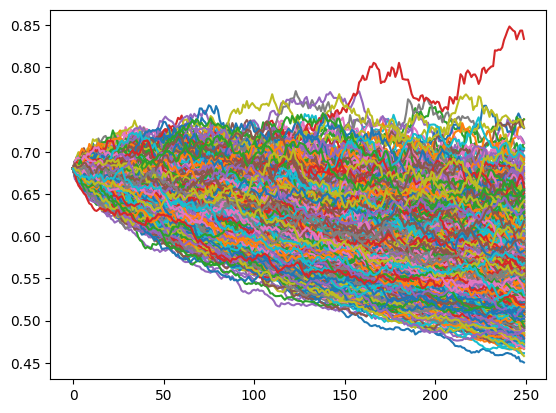

In [ ]:
plt.plot(compute_hedge(m, ds).squeeze(1).cpu().detach().numpy().T)

plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm

In [ ]:
d1 = (np.log(1 / 1.1) + (0 + 0.5 * 0.2 ** 2) * 1) / (0.2 * np.sqrt(1))
d2 = d1 - 0.2 * np.sqrt(1)

In [ ]:
1 * norm.cdf(d1) - 1.1 * norm.cdf(d2)

Black-Scholes formula in python

In [ ]:
import math
from scipy.stats import norm

def black_scholes_call(S, X, T, r, sigma):
    d1 = (math.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    call_price = S * norm.cdf(d1) - X * math.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, X, T, r, sigma):
    d1 = (math.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    put_price = X * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Example usage:
S0 = 1    # Current price of the underlying asset
X = 1.1     # Strike price of the option
T = 1       # Time to expiration in years
r = 0.00    # Risk-free interest rate
sigma = 0.2 # Volatility of the underlying asset

call_price = black_scholes_call(S0, X, T, r, sigma)
put_price = black_scholes_put(S0, X, T, r, sigma)

print(f"Call Option Price: {call_price:.2f}")
print(f"Put Option Price: {put_price:.2f}")

Call Option Price: 0.04
Put Option Price: 0.14


In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Calculate the Black-Scholes option price for European call or put options.

    Parameters:
    S (float): Current stock price (underlying asset price)
    K (float): Option strike price
    T (float): Time to expiration in years
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the underlying asset (annualized)
    option_type (str): Type of the option - "call" or "put"

    Returns:
    float: Theoretical price of the option
    """

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        # Call option price using Black-Scholes formula
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        # Put option price using Black-Scholes formula
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# Example usage:
S = 1  # Current stock price
K = 1.1  # Option strike price
T = 1    # Time to maturity (1 year)
r = 0.00  # Risk-free interest rate (5%)
sigma = 0.2  # Volatility (20%)

# Calculate the price of a European call option
call_price = black_scholes(S, K, T, r, sigma, option_type="call")
print(f"Call Option Price: {call_price:.2f}")

# Calculate the price of a European put option
put_price = black_scholes(S, K, T, r, sigma, option_type="put")
print(f"Put Option Price: {put_price:.2f}")

Lookback options

In [ ]:
import numpy as np

def simulate_gbm(S0, T, r, sigma, M, I):
    """ Simulate I paths with M time steps """
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return S

def lookback_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='call', floating_strike=True):
    """ Monte Carlo pricing for lookback options """
    S = simulate_gbm(S0, T, r, sigma, M, I)

    if floating_strike:
        if option_type == 'call':
            payoff = S[-1] - np.min(S, axis=0)
        elif option_type == 'put':
            payoff = np.max(S, axis=0) - S[-1]
    else:
        if option_type == 'call':
            payoff = np.max(S, axis=0) - K
        elif option_type == 'put':
            payoff = K - np.min(S, axis=0)

    payoff = np.maximum(payoff, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

# Parameters
S0 = 1    # Initial stock price
K = 1.1     # Strike price (used for fixed strike options)
T = 1.0     # Time to maturity in years
r = 0.00    # Risk-free interest rate
sigma = 0.2 # Volatility
M = 50      # Number of time steps
I = 10000   # Number of simulations

# Floating Strike Lookback Call Option
lookback_call_price = lookback_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='call', floating_strike=True)
print(f"Floating Strike Lookback Call Option Price: {lookback_call_price:.2f}")

# Floating Strike Lookback Put Option
lookback_put_price = lookback_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='put', floating_strike=True)
print(f"Floating Strike Lookback Put Option Price: {lookback_put_price:.2f}")

# Fixed Strike Lookback Call Option
lookback_fixed_call_price = lookback_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='call', floating_strike=False)
print(f"Fixed Strike Lookback Call Option Price: {lookback_fixed_call_price:.2f}")

# Fixed Strike Lookback Put Option
lookback_fixed_put_price = lookback_option_monte_carlo(S0, K, T, r, sigma, M, I, option_type='put', floating_strike=False)
print(f"Fixed Strike Lookback Put Option Price: {lookback_fixed_put_price:.2f}")

Floating Strike Lookback Call Option Price: 0.14
Floating Strike Lookback Put Option Price: 0.15
Fixed Strike Lookback Call Option Price: 0.08
Fixed Strike Lookback Put Option Price: 0.24


In [ ]:
import math
from scipy.stats import norm

def lookback_call_floating(S, sigma, r, T):
    """ Price of a floating strike lookback call option """
    d1 = (r + 0.5 * sigma**2) * T / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    call_price = S * (norm.cdf(d1) - sigma**2 / (2 * r) * (norm.cdf(-d1) - math.exp(-r * T) * norm.cdf(-d2)))
    return call_price

def lookback_put_floating(S, sigma, r, T):
    """ Price of a floating strike lookback put option """
    d1 = (r + 0.5 * sigma**2) * T / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    put_price = S * (norm.cdf(-d1) + sigma**2 / (2 * r) * (norm.cdf(d1) - math.exp(-r * T) * norm.cdf(d2)))
    return put_price

# Example usage:
S0 = 1    # Current price of the underlying asset
T = 1       # Time to expiration in years
r = 0.00    # Risk-free interest rate
sigma = 0.2 # Volatility of the underlying asset

lookback_call_price = lookback_call_floating(S0, sigma, r, T)
lookback_put_price = lookback_put_floating(S0, sigma, r, T)

print(f"Floating Strike Lookback Call Option Price: {lookback_call_price:.2f}")
print(f"Floating Strike Lookback Put Option Price: {lookback_put_price:.2f}")

ZeroDivisionError: float division by zero

In [ ]:
import numpy as np

def monte_carlo_lookback(S0, K, T, r, sigma, n_simulations=10000, n_steps=252, option_type='call', fixed_strike=True):
    """
    Monte Carlo simulation for lookback options pricing.

    Parameters:
    S0 (float): Initial stock price
    K (float): Strike price (only for fixed strike options)
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the stock (annualized)
    n_simulations (int): Number of simulations
    n_steps (int): Number of steps in each simulation
    option_type (str): 'call' or 'put'
    fixed_strike (bool): True for fixed strike, False for floating strike

    Returns:
    float: Theoretical price of the lookback option
    """

    dt = T / n_steps
    discount_factor = np.exp(-r * T)

    # Simulate asset price paths
    S = np.zeros((n_simulations, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_simulations)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate the option payoff based on the option type and strike type
    if fixed_strike:
        if option_type == 'call':
            payoff = np.maximum(np.max(S, axis=1) - K, 0)
        elif option_type == 'put':
            payoff = np.maximum(K - np.min(S, axis=1), 0)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    else:
        if option_type == 'call':
            payoff = S[:, -1] - np.min(S, axis=1)
        elif option_type == 'put':
            payoff = np.max(S, axis=1) - S[:, -1]
        else:
            raise ValueError("option_type must be 'call' or 'put'")

    # Calculate the average discounted payoff
    option_price = discount_factor * np.mean(payoff)

    return option_price

# Example usage:
S0 = 1.0  # Current stock price
K = 1.1  # Strike price
T = 1     # Time to maturity (1 year)
r = 0.0  # Risk-free interest rate (5%)
sigma = 0.2  # Volatility (20%)

# Pricing a fixed strike lookback call option
lookback_call_fixed = monte_carlo_lookback(S0, K, T, r, sigma, option_type='call', fixed_strike=True)
print(f"Fixed Strike Lookback Call Option Price: {lookback_call_fixed:.2f}")

# Pricing a floating strike lookback put option
lookback_put_floating = monte_carlo_lookback(S0, K, T, r, sigma, option_type='put', fixed_strike=False)
print(f"Floating Strike Lookback Put Option Price: {lookback_put_floating:.2f}")

European binary options

In [ ]:
import numpy as np
from scipy.stats import norm

def european_binary_option(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the price of a European binary option using the Black-Scholes formula.

    Parameters:
    S (float): Current stock price (underlying asset price)
    K (float): Option strike price
    T (float): Time to expiration in years
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the underlying asset (annualized)
    option_type (str): Type of the option - "call" or "put"

    Returns:
    float: Theoretical price of the European binary option
    """

    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    if option_type == 'call':
        # Binary call option price
        option_price = np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Binary put option price
        option_price = np.exp(-r * T) * norm.cdf(-d2)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# Example usage:
S = 100  # Current stock price
K = 100  # Option strike price
T = 1    # Time to expiration (1 year)
r = 0.05  # Risk-free interest rate (5%)
sigma = 0.2  # Volatility (20%)

# Price a European binary call option
binary_call_price = european_binary_option(S, K, T, r, sigma, option_type='call')
print(f"European Binary Call Option Price: {binary_call_price:.4f}")

# Price a European binary put option
binary_put_price = european_binary_option(S, K, T, r, sigma, option_type='put')
print(f"European Binary Put Option Price: {binary_put_price:.4f}")